## Evaluate model on ECDC dataset with confusion matrices

In [1]:
import torch
from tqdm import tqdm, trange
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from numpy.linalg import norm

In [2]:
# import trained siamese network

import nbimporter
from siamese_network_torch import SiameseNetwork
siamese_net = SiameseNetwork()
siamese_net.load_state_dict(torch.load('siamese_network_torch.pth'))
siamese_net.eval()

SiameseNetwork(
  (network): Sequential(
    (0): Linear(in_features=768, out_features=1028, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1028, out_features=1028, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1028, out_features=768, bias=True)
  )
)

In [17]:
embeddings = torch.load("training_data_10000.pt",  map_location=torch.device("cpu"))

In [18]:
langpair = "en-nb"

X_pairs = []
Y_labels = []
for embedding in tqdm(embeddings):
    X_pairs.append([
        embedding["embed1"].numpy(),
        embedding["embed2"].numpy()
    ])
    Y_labels.append(0 if embedding["equal"] else 1)

100%|██████████| 52474/52474 [00:00<00:00, 237250.07it/s]


In [19]:
class SiameseDataset(Dataset):
    def __init__(self, X_pairs, Y_labels):
        self.X_pairs = X_pairs
        self.Y_labels = Y_labels

    def __len__(self):
        return len(self.X_pairs)

    def __getitem__(self, index):
        # Convert the pairs and labels to PyTorch tensors
        pair = [torch.tensor(pair_elem, dtype=torch.float32) for pair_elem in self.X_pairs[index]]
        label = torch.tensor(self.Y_labels[index], dtype=torch.float32)

        return pair, label

In [20]:
testing_dataset = SiameseDataset(X_pairs, Y_labels)

batch_size = 32
shuffle = True
dataloader = DataLoader(testing_dataset, batch_size=batch_size, shuffle=shuffle)

100%|██████████| 1640/1640 [00:03<00:00, 440.50it/s]


Test Accuracy: 0.9098


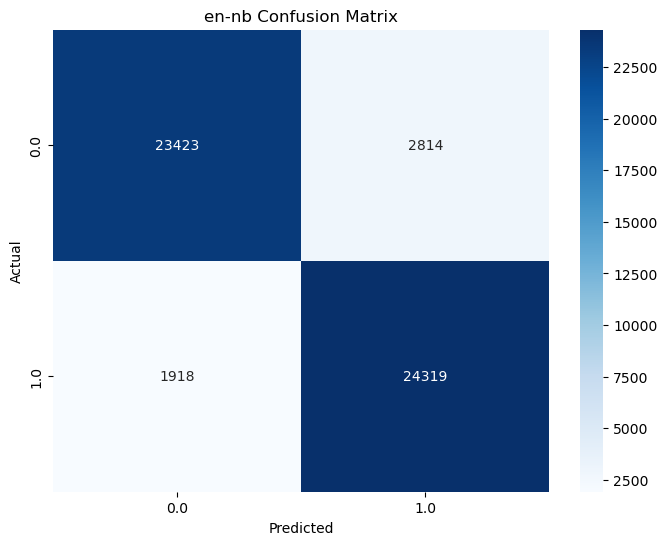

In [24]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

siamese_net.eval()
# Variables to keep track of correct predictions and total samples
correct_predictions = 0
total_samples = 0

dataloader = DataLoader(testing_dataset, batch_size=batch_size, shuffle=shuffle)

all_predictions = []
all_labels = []  # To store all the ground truth labels

# Iterate over the test DataLoader
for batch_data, batch_labels in tqdm(dataloader):
    # Move the batch data and labels to the GPU
    if torch.cuda.is_available():
        input1, input2 = batch_data[0].cuda(), batch_data[1].cuda()
        labels = batch_labels.cuda()
    else:
        input1, input2 = batch_data[0], batch_data[1]
        labels = batch_labels
        
    # Forward pass
    output1, output2 = siamese_net(input1, input2)

    # Calculate distances and make predictions
    distances = nn.functional.pairwise_distance(output1, output2)
    predictions = (distances < 0.5).float()  # Adjust threshold as needed

    # Update correct predictions and total samples
    correct_predictions += torch.sum(predictions == labels).item()
    total_samples += len(labels)
    
    # Append predictions and labels to the lists
    all_predictions.extend(predictions.cpu().detach().numpy())
    all_labels.extend(labels.cpu().detach().numpy())

# Calculate accuracy
accuracy = correct_predictions / total_samples
print(f'Test Accuracy: {accuracy:.4f}')

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(all_labels), yticklabels=np.unique(all_labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'{langpair} Confusion Matrix')
plt.show()
